# Importing Libraries

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [2]:
assess0 = pd.read_csv("F:\\HMH\\Data\\assessments0.csv", delimiter='|')
assess1 = pd.read_csv("F:\\HMH\\Data\\assessments1.csv", delimiter='|')
assess2 = pd.read_csv("F:\\HMH\\Data\\assessments2.csv", delimiter='|')
assess3 = pd.read_csv("F:\\HMH\\Data\\assessments3.csv", delimiter='|')
assess4 = pd.read_csv("F:\\HMH\\Data\\assessments4.csv", delimiter='|')

# Data Cleaning and Removal

In [3]:
# Duplication Removal
data1 = [assess0, assess1, assess2, assess3, assess4]
data = pd.concat(data1).reset_index()
print("Data merging done, there are " +str(len(data)) + " records.")
data = data.drop(['index'],axis=1)
Data = data.drop_duplicates()
print("Duplicates Removed: " + str(len(data)-len(Data)))

# String Replace
Data['District_ID'] = Data['district_id'].str.replace("district_","")
Data['School_ID'] = Data['school_id'].str.replace("school_","")
Data['Student_ID'] = Data['student_id'].str.replace("student_","")
Data['Assess_ID'] = Data['assessment_id'].str.replace("assessment_","")
Data['Item_ID'] = Data['item_id'].str.replace("item_","")

Data['item_score'] = Data['item_score'].fillna(0)
Data.loc[(Data['item_score'] < 0), 'item_score'] = 0  # Replacing -1 values with 0 in 'item_score' column
Data['item_score'] = Data['item_score'].astype(int)
new_assess = Data[Data['attempted'].notna()]

negative_time = new_assess[new_assess['time_in_seconds']<0].index
new_assess.drop(negative_time , inplace=True)
print("Negative time records is dropped.")

new_assess['attempted'] = new_assess['attempted'].astype(str)
fal_1 = new_assess[(new_assess['attempted']=='False') & (new_assess['item_score']==1)].index
new_assess.drop(fal_1,inplace=True)
print("Students with score 1 & who has not attempted the questions('False') records is dropped.")

# Checking Missing Values
for col in new_assess.columns:
    pct_missing = np.mean(new_assess[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
print("No missing values in the data.")

state_abr = {'CA':'California','IL':'Illinois','KS':'Kansas','ME':'Maine','TX':'Texas'}
new_assess["States"] = new_assess.state_id.map(state_abr)
new_assess['States'] = new_assess['States'].str.upper()

# Converting obj to datetime format
new_assess['session_completed'] = pd.to_datetime(new_assess['session_completed']) 
new_assess['year'] = pd.DatetimeIndex(new_assess['session_completed']).year
new_assess['month'] = pd.DatetimeIndex(new_assess['session_completed']).month
new_assess['day'] = new_assess['session_completed'].dt.day_name()
print("Total records removed after data cleaning: " + str(len(data)-len(new_assess)))
print("Data is clean, Good to proceed with " + str(len(new_assess)) + " records.")

Data merging done, there are 1193328 records.
Duplicates Removed: 129554
Negative time records is dropped.
Students with score 1 & who has not attempted the questions('False') records is dropped.
state_id - 0%
district_id - 0%
school_id - 0%
student_id - 0%
session_id - 0%
subject - 0%
grade - 0%
assessment_id - 0%
item_id - 0%
item_position - 0%
attempted - 0%
item_score - 0%
time_in_seconds - 0%
session_completed - 0%
District_ID - 0%
School_ID - 0%
Student_ID - 0%
Assess_ID - 0%
Item_ID - 0%
No missing values in the data.
Total records removed after data cleaning: 145780
Data is clean, Good to proceed with 1047548 records.


In [4]:
new_assess.head(5)

,state_id,district_id,school_id,student_id,session_id,subject,grade,assessment_id,item_id,item_position,...,session_completed,District_ID,School_ID,Student_ID,Assess_ID,Item_ID,States,year,month,day
0,TX,district_5,school_173,student_1749,91642,geography,4,assessment_3887,item_1099,8,...,2011-01-07 19:04:00,5,173,1749,3887,1099,TEXAS,2011,1,Friday
1,CA,district_12,school_97,student_2886,64977,geography,5,assessment_3768,item_18011,7,...,2010-08-09 18:57:00,12,97,2886,3768,18011,CALIFORNIA,2010,8,Monday
2,CA,district_2,school_279,student_570,102389,history,2,assessment_1776,item_16937,2,...,2011-02-24 18:50:00,2,279,570,1776,16937,CALIFORNIA,2011,2,Thursday
3,TX,district_4,school_295,student_3275,189539,geography,4,assessment_1939,item_8888,1,...,2010-09-29 20:15:00,4,295,3275,1939,8888,TEXAS,2010,9,Wednesday
4,ME,district_6,school_25,student_1552,152027,history,3,assessment_1399,item_6460,3,...,2011-01-05 21:59:00,6,25,1552,1399,6460,MAINE,2011,1,Wednesday


# Data Anaysis

In [5]:
# Assessment Score of Students
stu_unq = new_assess['student_id'].unique()
Students_Per = []
for i in range(0,len(stu_unq)):
    stu_unq1 = stu_unq[i]
    stu = new_assess[new_assess['student_id']==stu_unq1].reset_index()
    stu_sta = stu['States'][0]
    stu_dis = stu['district_id'][0]
    stu_sch = stu['school_id'][0]
    stu_sub = stu['subject'][0]
    stu_grd = stu['grade'][0]
    time = round(stu['time_in_seconds'].mean(),2)
    total_item = len(stu['item_id'])               #Number of items
    correct_item = len(stu[stu['item_score']==1])  #Sum of correct items
    Student_score = round(((correct_item/total_item)*100),2)#.astype(int)
    df = [stu_sta,stu_dis,stu_unq1,stu_sch,stu_grd,stu_sub,Student_score,time]
    Students_Per.append(df)
    #print(i)

Students_Performance = pd.DataFrame(Students_Per,columns=['State','District','Student','School','Grade','Subject','Student Score','Assess_Time'])
bins = [0,30,60,90,100]      # Grading bucket
labels = ['C', 'B', 'A','A+']
Students_Performance['grade'] = pd.cut(x = Students_Performance['Student Score'], bins = bins, labels = labels, include_lowest = True)

In [126]:
Students_Performance.head()

,State,District,Student,School,Grade,Subject,Student Score,Assess_Time,grade
0,TEXAS,district_5,student_1749,school_173,4,geography,97.97,76.91,A+
1,CALIFORNIA,district_12,student_2886,school_97,5,geography,82.70,4714.44,A
2,CALIFORNIA,district_2,student_570,school_279,2,history,79.84,28.22,A
3,TEXAS,district_4,student_3275,school_295,4,geography,76.13,112.47,A
4,MAINE,district_6,student_1552,school_25,3,history,0.00,50.04,C


In [8]:
# Student performance in the year 2010
stu_unq = new_assess['student_id'].unique()
new_assess10 = new_assess[new_assess['year']==2010]#.drop(['index'],axis=1)
Students_Per = []
for i in range(0,len(stu_unq)):
    stu_unq1 = stu_unq[i]
    stu = new_assess10[new_assess10['student_id']==stu_unq1].reset_index()
    if len(stu) > 0:
        stu_sta = stu['States'][0]
        stu_dis = stu['district_id'][0]
        stu_sch = stu['school_id'][0]
        stu_sub = stu['subject'][0]
        total_item = len(stu['item_id'])
        correct_item = len(stu[stu['item_score']==1])
        Student_score = round(((correct_item/total_item)*100),2)#.astype(int)
        df = [stu_sta,stu_dis,stu_unq1,stu_sch,stu_sub,Student_score]
        Students_Per.append(df)
        #print(i)

Students_Performance10 = pd.DataFrame(Students_Per,columns=['State','District','Student','School','Subject','Student Score 2010'])

# Student performance in the year 2011
stu_unq = new_assess['student_id'].unique()
new_assess11 = new_assess[new_assess['year']==2011]#.drop(['index'],axis=1)
Students_Per = []
for i in range(0,len(stu_unq)):
    stu_unq1 = stu_unq[i]
    stu = new_assess11[new_assess11['student_id']==stu_unq1].reset_index()
    if len(stu) > 0:
        stu_sta = stu['States'][0]
        stu_dis = stu['district_id'][0]
        stu_sch = stu['school_id'][0]
        stu_sub = stu['subject'][0]
        total_item = len(stu['item_id'])
        correct_item = len(stu[stu['item_score']==1])
        Student_score = round(((correct_item/total_item)*100),2)#.astype(int)
        df = [stu_sta,stu_dis,stu_unq1,stu_sch,stu_sub,Student_score]
        Students_Per.append(df)
        #print(i)

Students_Performance11 = pd.DataFrame(Students_Per,columns=['State','District','Student','School','Subject','Student Score 2011'])


In [14]:
# Student performance on each assessments
Assess_Score = []
unq_stu = new_assess['student_id'].unique()
for i in range(0,len(unq_stu)):
    stu_data = new_assess[new_assess['student_id']==unq_stu[i]].reset_index().drop(['index'],axis=1)
    if len(stu_data)>0:
        unq_assess = stu_data['assessment_id'].unique()
        #print(i)
        for j in range(0,len(unq_assess)):
            assess_data = stu_data[stu_data['assessment_id']==unq_assess[j]].reset_index().drop(['index'],axis=1)
            if len(assess_data)>0:
                time_taken = sum(assess_data['time_in_seconds'])
                total_item = len(assess_data['item_id'])
                correct_item = len(assess_data[assess_data['item_score']==1])
                Student_score = round(((correct_item/total_item)*100),2)#.astype(int)
                day = assess_data['day'][0]
                assignment = unq_assess[j]
                student = unq_stu[i]
                df = [student,assignment,day,time_taken,Student_score]
                Assess_Score.append(df)
                
Assessment_Score = pd.DataFrame(Assess_Score,columns=['Student','Assignment','Day','Assess_Time','Student Score'])
Assessment_Score['Time_Min'] = round(Assessment_Score['Assess_Time']/60,2)

In [127]:
Assessment_Score.head()

,Student,Assignment,Day,Assess_Time,Student Score,Time_Min
0,student_1749,assessment_3887,Friday,91,100.0,1.52
1,student_1749,assessment_2690,Thursday,624,100.0,10.40
2,student_1749,assessment_1008,Tuesday,700,100.0,11.67
3,student_1749,assessment_3416,Tuesday,338,100.0,5.63
4,student_1749,assessment_4404,Friday,227,100.0,3.78


# Part - 1
# Insight for CEO

## Student performance

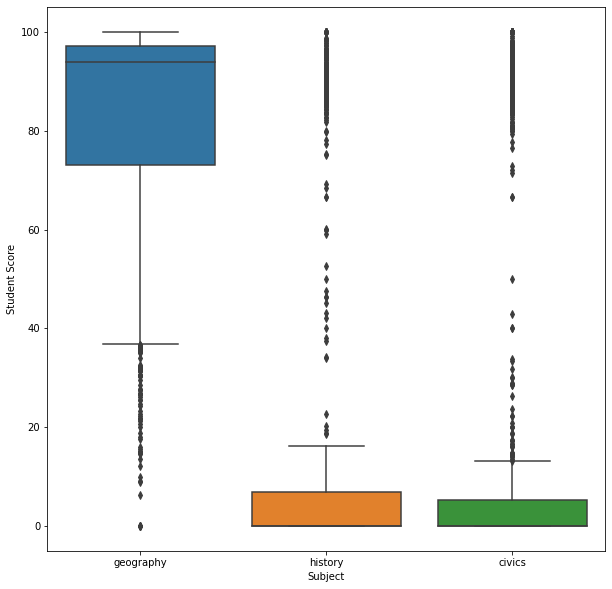

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(Students_Performance['Subject'],Students_Performance['Student Score'])
plt.show()

### Comparing students's grade with student performance

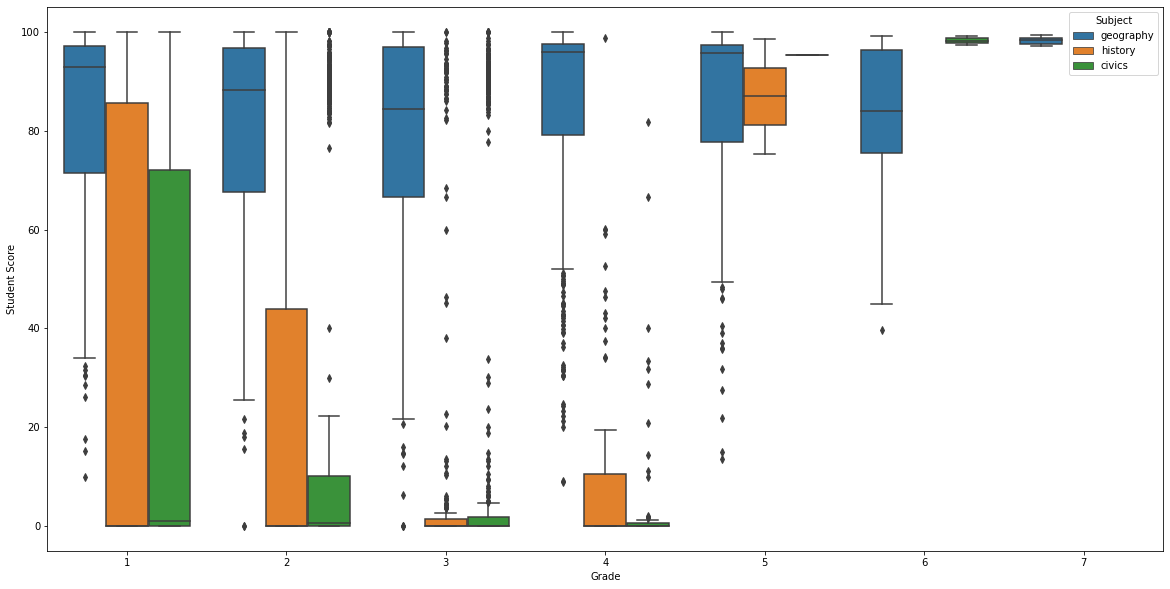

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(Students_Performance['Grade'],Students_Performance['Student Score'],hue=Students_Performance['Subject'])
plt.show()

In [44]:
dim22 = pd.DataFrame(new_assess.groupby(['subject','grade'])['assessment_id'].nunique().round()).reset_index()
dim22

,subject,grade,assessment_id
0,civics,1,236
1,civics,2,277
2,civics,3,252
3,civics,4,82
4,civics,5,22
5,civics,6,9
6,geography,0,2
7,geography,1,830
8,geography,2,608
9,geography,3,759


### Comparing students's from different state with student performance

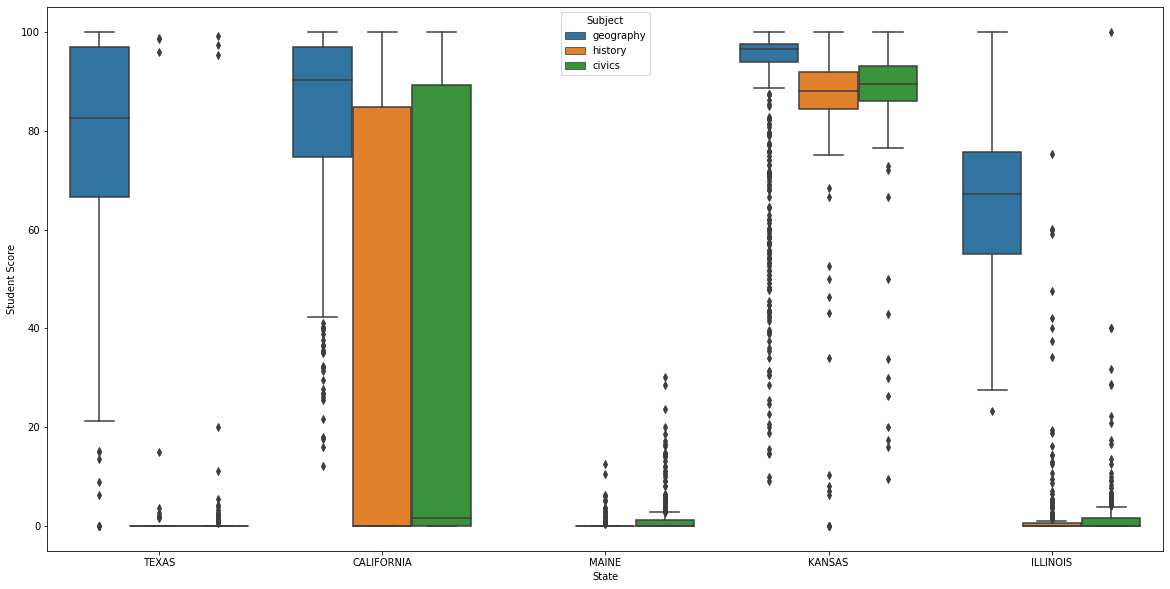

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(Students_Performance['State'],Students_Performance['Student Score'],hue=Students_Performance['Subject'])
plt.show()

In [46]:
st_dis = pd.DataFrame(new_assess.groupby(['subject','States'])['assessment_id'].nunique().round()).reset_index()
st_dis

,subject,States,assessment_id
0,civics,CALIFORNIA,358
1,civics,ILLINOIS,458
2,civics,KANSAS,533
3,civics,MAINE,434
4,civics,TEXAS,253
5,geography,CALIFORNIA,2449
6,geography,ILLINOIS,980
7,geography,KANSAS,1992
8,geography,TEXAS,2450
9,history,CALIFORNIA,166


### Insight:
- Higher the assessments provided to the students, better their performance.
    

# Insight for Product Owner

## Student performance on assessments

In [53]:
dim3 = pd.DataFrame(new_assess.groupby(['States','attempted'])['grade'].count()).reset_index()
dim3.columns = dim3.columns.str.replace('grade', 'Count')
dim3

,States,attempted,Count
0,CALIFORNIA,False,224
1,CALIFORNIA,True,321332
2,ILLINOIS,False,137
3,ILLINOIS,True,92519
4,KANSAS,False,203
5,KANSAS,True,356926
6,MAINE,True,74506
7,TEXAS,False,462
8,TEXAS,True,201239


In [54]:
dim4 = pd.DataFrame(new_assess.groupby(['subject','attempted'])['grade'].count()).reset_index()
dim4.columns = dim4.columns.str.replace('grade', 'Count')
dim4

,subject,attempted,Count
0,civics,True,165069
1,geography,False,1026
2,geography,True,819383
3,history,True,62070


In [55]:
new_assess_geof = new_assess[(new_assess['subject']=='geography')&(new_assess['attempted']=='False')]
#new_assess_geo['Time1'] = new_assess_geo['session_completed'].dt.round("H")
#new_assess_geo['Time'] = new_assess_geo['Time1'].dt.strftime('%H:%M')
dim5 = pd.DataFrame(new_assess_geof.groupby(['item_position'])['student_id'].nunique()).reset_index()
dim5.columns = ['Item_Position','Stu_NoAtt']
new_assess_geot = new_assess[(new_assess['subject']=='geography')&(new_assess['attempted']=='True')]
dim6 = pd.DataFrame(new_assess_geot.groupby(['item_position'])['student_id'].nunique()).reset_index()
dim6.columns = ['Item_Position','Stu_Att']
df2 = pd.merge(dim5, dim6, on=['Item_Position'])
df2['Total'] = df2['Stu_NoAtt']+df2['Stu_Att']
df2['NoAtt %'] = (df2['Stu_NoAtt']/df2['Total'])*100
df2['Att %'] = (df2['Stu_Att']/df2['Total'])*100
df2

,Item_Position,Stu_NoAtt,Stu_Att,Total,NoAtt %,Att %
0,1,179,2752,2931,6.107131,93.892869
1,2,98,2744,2842,3.448276,96.551724
2,3,78,2726,2804,2.781740,97.218260
3,4,71,2725,2796,2.539342,97.460658
4,5,66,2687,2753,2.397385,97.602615
5,6,68,2645,2713,2.506450,97.493550
6,7,62,2597,2659,2.331704,97.668296
7,8,31,2472,2503,1.238514,98.761486
8,9,56,2364,2420,2.314050,97.685950
9,10,18,2349,2367,0.760456,99.239544


In [131]:
stu_geof = pd.DataFrame(new_assess_geof.groupby(['district_id'])['item_position'].count()).reset_index()
stu_geof.columns = ['District','Not Attempted']
stu_geof

,District,Not Attempted
0,district_10,137
1,district_12,206
2,district_13,14
3,district_14,4
4,district_4,443
5,district_5,19
6,district_7,121
7,district_9,82


In [87]:
d4 = new_assess_geof[new_assess_geof['district_id']=='district_4']
stu_d4 = pd.DataFrame(d4.groupby(['item_position'])['student_id'].count()).reset_index()
stu_d4

,item_position,student_id
0,1,123
1,2,63
2,3,55
3,4,36
4,5,30
5,6,29
6,7,40
7,8,17
8,9,18
9,10,2


### Students performance in 2010

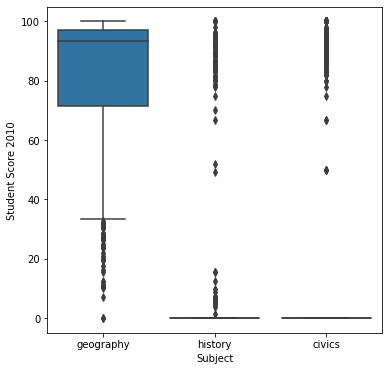

In [93]:
df3 = pd.merge(Students_Performance10, Students_Performance11, on=['State','District','Student','School','Subject'])
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(df3['Subject'],df3['Student Score 2010'])
plt.show()

### Students performance in 2011

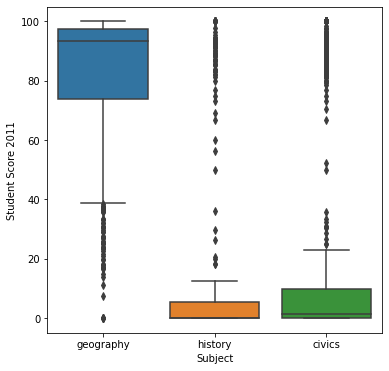

In [94]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(df3['Subject'],df3['Student Score 2011'])
plt.show()

In [132]:
sub_10 = pd.DataFrame(new_assess10.groupby(['subject'])['assessment_id'].nunique().round()).reset_index()
sub_10.columns = ['Subject','2010 Assessment']
sub_11 = pd.DataFrame(new_assess11.groupby(['subject'])['assessment_id'].nunique().round()).reset_index()
sub_11.columns = ['Subject','2011 Assessment']
sub_per = pd.merge(sub_10,sub_11,on=['Subject'])
sub_per['Total'] = sub_per['2010 Assessment']+sub_per['2011 Assessment']
sub_per

,Subject,2010 Assessment,2011 Assessment,Total
0,civics,706,674,1380
1,geography,3168,2636,5804
2,history,372,321,693


### Insight:
- Item position matter in framing the questions, earlier the questions from geography in assessments students are more likely to not attempt the question.
- Student performance have increased on comparing 2010 and 2011, because of more exposure to the assessments at the end of the academic year.

# Insight for Research Scholar

### Districts comparision on student performance

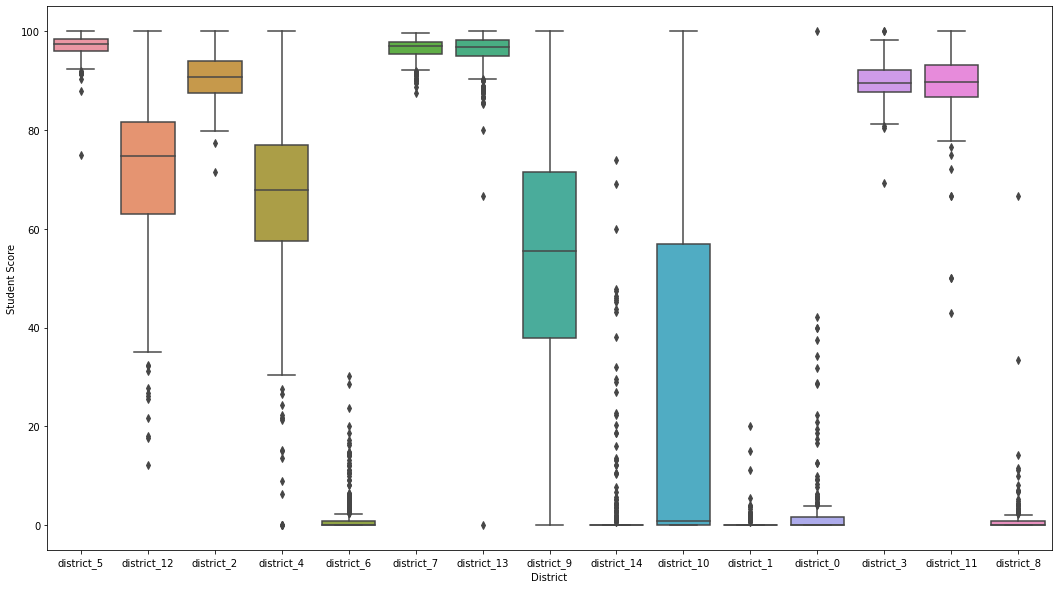

In [71]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.boxplot(Students_Performance['District'],Students_Performance['Student Score'])
plt.show()

In [133]:
# Top performing districts with assessment provided
dis_sub1 = new_assess.loc[new_assess.District_ID=='5']
dis_sub2 = new_assess.loc[new_assess.District_ID=='2']
dis_sub3 = new_assess.loc[new_assess.District_ID=='7']
dis_sub4 = new_assess.loc[new_assess.District_ID=='3']
dis_sub5 = new_assess.loc[new_assess.District_ID=='13']
dis_sub6 = new_assess.loc[new_assess.District_ID=='11']
d1 = [dis_sub1,dis_sub2,dis_sub3,dis_sub4,dis_sub5,dis_sub6]
dis_sub = pd.concat(d1).reset_index()
dis_sub1 = dis_sub.drop(['index'],axis=1)
dis_sub1 = pd.DataFrame(dis_sub.groupby(['subject'])['assessment_id'].nunique().round()).reset_index()
#dis_sub1['Assessment %'] = (dis_sub1['assessment_id'].div(sum(dis_sub1['assessment_id']))*100).round()
dis_sub1

,subject,assessment_id
0,civics,651
1,geography,2752
2,history,280


In [134]:
# Low performing districs with assessment provided
dis_sub7 = new_assess.loc[new_assess.District_ID=='6']
dis_sub8 = new_assess.loc[new_assess.District_ID=='14']
dis_sub9 = new_assess.loc[new_assess.District_ID=='1']
dis_sub10 = new_assess.loc[new_assess.District_ID=='0']
dis_sub11 = new_assess.loc[new_assess.District_ID=='8']
d2 = [dis_sub7,dis_sub8,dis_sub9,dis_sub10,dis_sub11]
dis_subb = pd.concat(d2).reset_index()
dis_subb = dis_subb.drop(['index'],axis=1)
dis_sub11 = pd.DataFrame(dis_subb.groupby(['subject'])['assessment_id'].nunique().round()).reset_index()
#dis_sub11['Assessment %'] = (dis_sub11['assessment_id'].div(sum(dis_sub11['assessment_id']))*100).round()
dis_sub11

,subject,assessment_id
0,civics,595
1,geography,32
2,history,275


In [74]:
print("Total Assessment for top performing districts: " + str(sum(dis_sub1['assessment_id'])))
print("Total Assessment for low performing districts: " + str(sum(dis_sub11['assessment_id'])))

Total Assessment for top performing districts: 3683
Total Assessment for low performing districts: 902


### Insight:
- Assessment from geography plays a vital role in deciding the student performance, also the total number of assessments.

### Correlation between students assessments and average score

In [111]:
stu_asses = pd.DataFrame(Assessment_Score.groupby(['Student'])['Assignment'].nunique().round()).reset_index()
stu_avg = pd.DataFrame(Assessment_Score.groupby(['Student'])['Student Score'].mean().round()).reset_index()
stu_asses_avg = pd.merge(stu_asses, stu_avg, on=['Student'])

cor = np.corrcoef(stu_asses_avg['Assignment'], stu_asses_avg['Student Score'])[0,1]
print("Correlation value: "+str(cor))

Correlation value: 0.3201440725049224


- Number of assessments has an effect on student performance.

# Part - 2

In [112]:
dim = pd.DataFrame(new_assess.groupby('state_id')['school_id'].nunique()).reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=dim['state_id'], # Spatial coordinates
    z = dim['school_id'],#.astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "School Count",
))

fig.update_layout(
    title_text = 'HMH Business',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [118]:
att_tru = new_assess[new_assess['attempted']=='True']
dim0 = pd.DataFrame(att_tru.groupby(['District_ID','States'])['school_id','student_id'].nunique()).reset_index()
dim0['Students per district'] = (dim0['student_id']/dim0['school_id']).round()
dim7 = pd.DataFrame(att_tru.groupby(['District_ID','States'])['time_in_seconds'].mean()).reset_index()
#dim7.sort_values(by=['time_in_seconds'], ascending=True).reset_index().drop(['index'],axis=1)
df2 = pd.merge(dim0, dim7, on=['District_ID','States'])
df2.sort_values(by=['time_in_seconds'], ascending=True).reset_index().drop(['index'],axis=1)

,District_ID,States,school_id,student_id,Students per district,time_in_seconds
0,14,CALIFORNIA,17,403,24.0,80.848546
1,13,CALIFORNIA,27,551,20.0,83.900216
2,3,CALIFORNIA,12,130,11.0,84.485543
3,1,TEXAS,17,206,12.0,121.211762
4,2,CALIFORNIA,9,159,18.0,121.863268
5,6,MAINE,46,722,16.0,122.602770
6,8,CALIFORNIA,20,255,13.0,153.437020
7,11,KANSAS,13,198,15.0,156.001287
8,9,KANSAS,13,146,11.0,204.292077
9,7,KANSAS,18,681,38.0,210.309668


### Our Hypothesis will be,

#### H0: Time spent on assessments has no effect on student performance
#### H1: Time spent on assessments has effect on student performance

### Days of the week effect on student performance

In [88]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
per_dim = pd.DataFrame(new_assess.groupby(['day'])['assessment_id'].nunique().round()).reindex(cats)
per_dim1 = pd.DataFrame(new_assess.groupby(['day'])['time_in_seconds'].mean().round()).reindex(cats)
per_dim1['time_min'] = round(per_dim1['time_in_seconds']/60,2)
perfor_day = pd.merge(per_dim, per_dim1, on=['day'])

per_dim2 = pd.DataFrame(Assessment_Score.groupby(['Day'])['Student Score'].mean().round()).reset_index()
per_dim2.columns = ['day','Student Score']
perfor_day1 = pd.merge(perfor_day,per_dim2,on=['day'])
perfor_day1

,day,assessment_id,time_in_seconds,time_min,Student Score
0,Monday,3417,217.0,3.62,63.0
1,Tuesday,3629,218.0,3.63,63.0
2,Wednesday,3695,212.0,3.53,62.0
3,Thursday,3713,219.0,3.65,60.0
4,Friday,3714,201.0,3.35,50.0
5,Saturday,937,474.0,7.90,84.0
6,Sunday,795,610.0,10.17,87.0


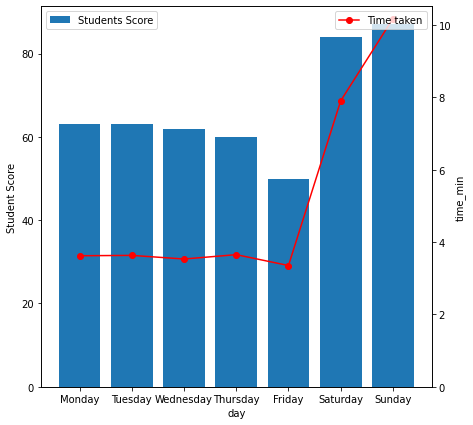

In [141]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel('day')
ax.bar('day','Student Score',data=perfor_day1,label="Students Score")
ax.set_ylabel('Student Score')
ax.set_ylim(ymin=0)
plt.legend(loc="upper left")
ax2 = ax.twinx()
ax2.plot('day','time_min',data=perfor_day1, marker='o', color='red',label="Time taken")
ax2.set_ylabel('time_min')
ax2.set_ylim(ymin=0)

plt.legend(loc="upper right")
plt.show()

In [125]:
Cor = pearsonr(perfor_day1['time_min'], perfor_day1['Student Score'])[0]
p_val = pearsonr(perfor_day1['time_min'], perfor_day1['Student Score'])[1]

print("Correlation value: "+str(Cor))
print("p-value: "+str(p_val))

Correlation value: 0.938816385517805
p-value: 0.0017205060824587119


### Insight:
- Higher the time they spend on assessments, better the performance of students.
- Time spent and student score is highly correlated.

## Report Generation

Do you want to look at district wise data? Type Y/N y
Select any district between 0 to 15: 5
Number of schools in this districts: 22
Total number of students: 350
Assessment subjects: ['geography' 'history' 'civics']
Students belongs to grade: [4 6 5 2 3 1 7 0]
Number of Assessments provided: 1616
Number of Questions provided: 7896
Students Performance: 97.05%


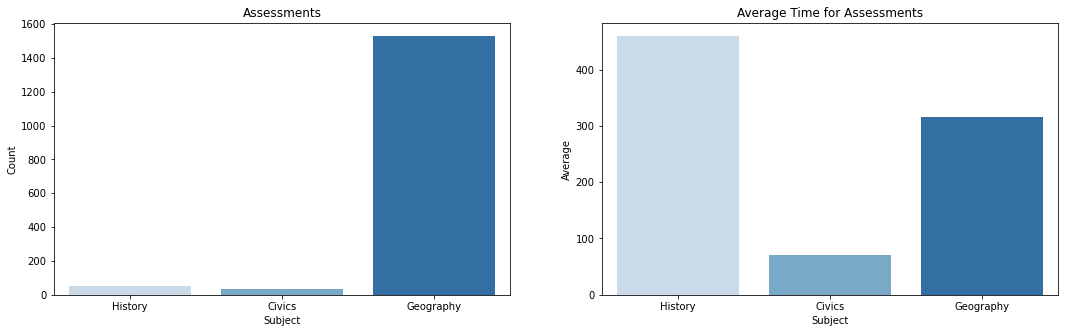

    grade    subject  time_in_seconds
0       0  geography              100
1       1  geography               64
2       2     civics               14
3       2  geography              138
4       2    history               16
5       3  geography              151
6       3    history              129
7       4     civics               38
8       4  geography              379
9       4    history              267
10      5     civics               99
11      5  geography              441
12      5    history              503
13      6     civics               34
14      6  geography              443
15      6    history               84
16      7  geography             1042
Do you want to look at district wise data? Type Y/N y
Select any district between 0 to 15: 7
Number of schools in this districts: 18
Total number of students: 681
Assessment subjects: ['geography']
Students belongs to grade: [4 5 6 7]
Number of Assessments provided: 960
Number of Questions provided: 5777
Students P

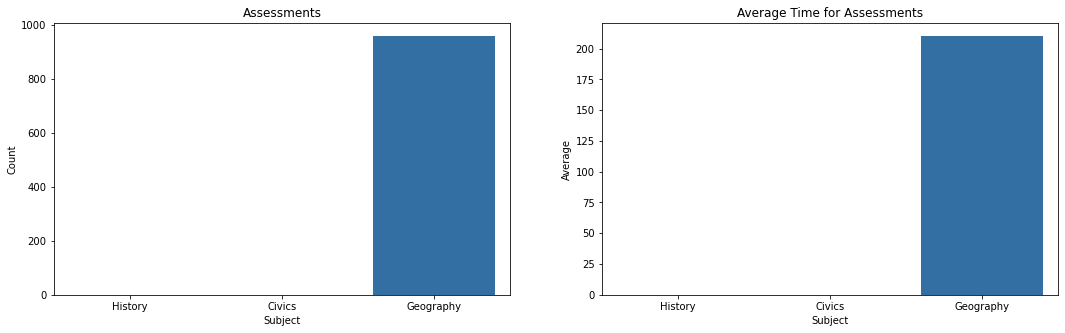

   grade    subject  time_in_seconds
0      4  geography              207
1      5  geography              215
2      6  geography              214
3      7  geography               22
Do you want to look at district wise data? Type Y/N n
Thank You


In [146]:
def main():
    while True:
        again = input("Do you want to look at district wise data? Type Y/N ").upper()

        if again == "N":
            print ("Thank You")
            return
        elif again == "Y":
            stat = str(input("Select any district between 0 to 15: ")).upper()
            if stat in list(att_tru['District_ID']):
                district = att_tru[att_tru['District_ID']==stat].reset_index()
                if len(district) == 0: print("No Data Available")
                else:
                    print("Number of schools in this districts: "+ str(len(district['school_id'].unique())))
                    print("Total number of students: "+str(len(district['student_id'].unique())))
                    print("Assessment subjects: "+str(district['subject'].unique()))
                    print("Students belongs to grade: "+str(district['grade'].unique()))
                    print("Number of Assessments provided: "+str(len(district['assessment_id'].unique())))
                    print("Number of Questions provided: "+str(len(district['item_id'].unique())))
                    
                    total_item = len(district['item_id'])
                    correct_item = len(district[district['item_score']==1])
                    score = round(((correct_item/total_item)*100),2)#.astype(int)
                    print("Students Performance: " +str(score) + "%")

                    his = district[district['subject']=='history']
                    civ = district[district['subject']=='civics']
                    geo = district[district['subject']=='geography']
                    HIS = len(his['assessment_id'].unique())
                    CIV = len(civ['assessment_id'].unique())
                    GEO = len(geo['assessment_id'].unique())
                    Sub = pd.DataFrame({'Subject':['History','Civics','Geography'],'Count':[HIS,CIV,GEO]})

                    avg_his = round(his['time_in_seconds'].mean(),2)
                    avg_civ = round(civ['time_in_seconds'].mean(),2)
                    avg_geo = round(geo['time_in_seconds'].mean(),2)
                    avg = pd.DataFrame({'Subject':['History','Civics','Geography'],'Average':[avg_his,avg_civ,avg_geo]}).fillna(0)

                    plt.figure(figsize=(18,5))
                    plt.subplot(1, 2, 1)
                    sns.barplot(x='Subject',y='Count',data=Sub,palette="Blues").set(title='Assessments')
                    plt.subplot(1, 2, 2)
                    sns.barplot(x='Subject',y='Average',data=avg,palette="Blues").set(title='Average Time for Assessments')

                    plt.show()
                    
                    sub_gra = pd.DataFrame(district.groupby(['grade','subject'])['time_in_seconds'].mean()).round().reset_index()
                    sub_gra['time_in_seconds'] = sub_gra['time_in_seconds'].astype(int)
                    print(sub_gra)

                    #Pie
                    #plt.pie(Grp_Dec['index'],labels = Grp_Dec['declarationType1'],autopct='%1.1f%%',explode=[0,0,0], shadow=True, startangle=50)
                    #plt.show()

            else: print("Entered state is not in the list, Kindly check again.")
        else:
            print ("Please enter either \"Y\" or \"N\".")

if __name__ == "__main__":
    main()

# Key Takeaways & Plan

- Student performance will increase with number of assessments provided.
- Performance of students have increased when comparing 2010 and 2011.
- More assessments should be given in history and civics.
- More concentration to be given to students in 'Maine' states.
- More time they spend on assessments, their performance have got better.